### Machine Learning Model Development

1. Datasource:
    - https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset

2. Objective:
    - To classify a person into abnormal or normal using collected physical spine data.
    
3. Encoding:
    - Normal = 0 | Abnormal(Patient) = 1
    
4. Metrics:
    - For medical datasets, it is important to reduce False Negative i.e. a Patient must not be mis classified as normal.
    - In other words, typically Recall must be improved.
    - However, my focus would be to improve the overall accuracy.
    
5. Scope:
    - Limited to the models used with hyperparameter tuning with few parameters and levels.(Hardware limitations)

6. Recommendation from Exploratory Data Analyses (EDA)
    - Drop pelvic_incidence
    - Use StandarScaler.
    - Downsampling / Upsampling.

In [1]:
# Import Relevant Libraries

# -------------- Basic Libraries ----------------------
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
import seaborn as sns
import pandas as pd
pd.set_option('display.max_columns', 10000)
pd.options.display.width=None
from tabulate import tabulate
tabulate.PRESERVE_WHITESPACE = False

# --------------- sklearn libraries ---------------------

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import catboost as cb

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation, Dropout
from tensorflow.keras.models import Sequential

In [2]:
# Global constants

RND_STATE = 39  # random_state where used is assigned RND_STATE
TESTSIZE = 0.2  # test_size where used is assigned TESTSIZE

In [3]:
PATH = r"C:\DSML_Case_Studies\01_Classification\01_Dataset"
OUTPATH = r"C:\DSML_Case_Studies\01_Classification\03_Output"
DATASET = r"\Dataset_Lower_Back_Pain_12x1.csv"
PREFIX = r"\Back_Pain_"

# Specify number of features and targets

n_features = 12
n_target = 1

In [4]:
# Dataframe Definition & Classifying Features & Targets

df = pd.read_csv(f"{PATH}{DATASET}")
df = df.drop(columns='pelvic_incidence')
df = df.round(decimals=3)

collst = []
for columns in df.columns:
    collst.append(columns)

featlst = collst[0:len(collst)-n_target]
targlst = collst[-n_target:]

cat_df = df.select_dtypes(include=['object'])
catlst = []
for col in cat_df.columns:
    catlst.append(col)

y_catlst = [value for value in catlst if value in targlst]

In [5]:
print("Dataframe BEFORE Encoding: ")

Dataframe BEFORE Encoding: 


In [6]:
df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,Normal
1,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,Patient
2,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,Normal
3,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,Patient
4,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,Patient


In [7]:
# Encode Categorical Columns

for i in range(0, len(collst), 1):
    temp = df.dtypes[collst[i]]
    if temp == 'object':
        df[collst[i]] = df[collst[i]].astype('category')
        df[collst[i]] = df[collst[i]].cat.codes
    else:
        continue
        
# Features & Target DataFrame

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

In [8]:
print("Dataframe AFTER Encoding: ")

Dataframe AFTER Encoding: 


In [9]:
df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope,Class_att
0,10.689,54.000,37.117,125.391,-0.403,0.750,32.811,12.050,15.659,-4.137,39.620,0
1,35.393,77.417,56.634,115.724,58.058,0.302,30.016,9.832,11.212,-19.265,19.997,1
2,21.345,66.000,42.447,119.550,12.383,0.608,21.560,8.023,8.727,-8.842,34.572,0
3,11.079,32.137,35.311,98.775,6.387,0.065,14.283,7.452,7.302,-24.361,28.237,1
4,15.225,67.632,49.399,90.298,31.326,0.782,24.763,18.598,13.018,-20.526,17.355,1


In [10]:
print("Dataframe BEFORE Imputing: ")

Dataframe BEFORE Imputing: 


In [11]:
print(df.isnull().sum(), end='\n\n')

pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [12]:
# Basic Imputing

''' Use Appropriate Imputer - Mean, Meadian, Mode... Others '''

df = df.apply(lambda x: x.fillna(x.median()), axis=0)

In [13]:
print("Dataframe AFTER MEDIAN Imputing: ")

Dataframe AFTER MEDIAN Imputing: 


In [14]:
print(df.isnull().sum(), end='\n\n')

pelvic_tilt                 0
lumbar_lordosis_angle       0
sacral_slope                0
pelvic_radius               0
degree_spondylolisthesis    0
pelvic_slope                0
Direct_tilt                 0
thoracic_slope              0
cervical_tilt               0
sacrum_angle                0
scoliosis_slope             0
Class_att                   0
dtype: int64



In [15]:
# Sanity checks before proceeding further

print("List of Features:", featlst, end='\n\n')
print("List of Targets:", targlst, end='\n\n')
print("List of Categorical Variables:", catlst, end='\n\n')
print("List of Categorical Targets", y_catlst, end='\n\n')

List of Features: ['pelvic_tilt', 'lumbar_lordosis_angle', 'sacral_slope', 'pelvic_radius', 'degree_spondylolisthesis', 'pelvic_slope', 'Direct_tilt', 'thoracic_slope', 'cervical_tilt', 'sacrum_angle', 'scoliosis_slope']

List of Targets: ['Class_att']

List of Categorical Variables: ['Class_att']

List of Categorical Targets ['Class_att']



In [16]:
print("Descriptive Stats: ")

Descriptive Stats: 


In [17]:
desc_stat = df.describe().T.round(3) # Univariate analyses
print(tabulate(desc_stat, headers=desc_stat.columns, tablefmt="github", numalign="right"))

|                          |   count |    mean |    std |     min |     25% |     50% |     75% |     max |
|--------------------------|---------|---------|--------|---------|---------|---------|---------|---------|
| pelvic_tilt              |     310 |  17.543 | 10.008 |  -6.555 |  10.667 |  16.358 |   22.12 |  49.432 |
| lumbar_lordosis_angle    |     310 |  51.931 | 18.554 |      14 |      37 |  49.562 |      63 | 125.742 |
| sacral_slope             |     310 |  42.954 | 13.423 |  13.367 |  33.347 |  42.405 |  52.696 |  121.43 |
| pelvic_radius            |     310 | 117.921 | 13.317 |  70.083 | 110.709 | 118.268 | 125.468 | 163.071 |
| degree_spondylolisthesis |     310 |  26.297 | 37.559 | -11.058 |   1.604 |  11.768 |  41.288 | 418.543 |
| pelvic_slope             |     310 |   0.473 |  0.286 |   0.003 |   0.225 |   0.476 |   0.705 |   0.999 |
| Direct_tilt              |     310 |  21.322 |  8.639 |   7.027 |  13.054 |  21.907 |  28.954 |  36.744 |
| thoracic_slope           |

In [18]:
# Train-Test Split

X = df.drop(columns=targlst)
y = df.drop(columns=featlst)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TESTSIZE, random_state=RND_STATE)


In [19]:
print("Train Dataset - Features: ")

Train Dataset - Features: 


In [20]:
X_train.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
139,1.507,46.110,42.709,108.630,42.810,0.481,20.060,14.732,11.990,5.366,13.711
17,23.138,62.582,42.474,124.128,-4.083,0.997,30.042,17.622,13.391,-16.370,21.450
159,5.268,86.000,65.973,110.703,38.260,0.506,23.053,15.243,14.149,-19.896,8.624
258,8.961,52.578,47.603,98.777,50.702,0.589,18.145,13.963,12.466,0.744,32.447
282,16.421,59.869,55.923,70.083,12.073,0.057,31.823,15.713,9.368,-33.489,28.948


In [21]:
print("Test Dataset - Features: ")

Test Dataset - Features: 


In [22]:
X_test.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
119,21.936,82.962,54.211,123.932,10.432,0.253,21.593,7.810,11.071,-34.898,43.149
266,15.724,58.619,58.841,105.417,0.599,0.118,18.055,15.624,10.546,-32.495,16.623
217,20.268,77.111,63.435,125.480,69.280,0.736,33.812,15.112,14.381,-20.214,11.735
21,34.311,78.423,49.086,110.467,49.672,0.772,24.926,7.624,13.236,-21.450,16.215
61,33.426,76.277,45.000,138.554,77.155,0.581,36.628,16.626,7.965,-19.123,16.143


In [23]:
print("Train Dataset - Target: ")

Train Dataset - Target: 


In [24]:
y_train.head()

,Class_att
139,1
17,0
159,1
258,1
282,1


In [25]:
print("Test Dataset - Target: ")

Test Dataset - Target: 


In [26]:
y_test.head()

,Class_att
119,1
266,0
217,1
21,1
61,1


In [27]:
# Scaling

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

X_train_sc_df = pd.DataFrame(scaler.fit_transform(X_train), columns=featlst)
X_test_sc_df = pd.DataFrame(scaler.transform(X_test), columns=featlst)

In [28]:
print("Train Dataset Scaled - Features:")

Train Dataset Scaled - Features:


In [29]:
X_train_sc_df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,-1.584408,-0.297755,0.000887,-0.697615,0.423091,0.041330,-0.109958,0.492350,0.044646,1.558448,-1.109482
1,0.570971,0.620227,-0.016680,0.448187,-0.769878,1.828750,1.056321,1.340374,0.523892,-0.187088,-0.361110
2,-1.209650,1.925307,1.740033,-0.544353,0.307338,0.127930,0.239739,0.642294,0.783184,-0.470248,-1.601401
3,-0.841668,0.062705,0.366748,-1.426069,0.623866,0.415441,-0.333703,0.266699,0.207473,1.187272,0.702314
4,-0.098332,0.469032,0.988725,-3.547479,-0.358865,-1.427402,1.264409,0.780209,-0.852272,-1.561850,0.363956


In [30]:
print("Test Dataset Scaled - Features:")

Test Dataset Scaled - Features:


In [31]:
X_test_sc_df.head()

,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,pelvic_slope,Direct_tilt,thoracic_slope,cervical_tilt,sacrum_angle,scoliosis_slope
0,0.451200,1.756000,0.860742,0.433696,-0.400613,-0.748459,0.069155,-1.538802,-0.269720,-1.675002,1.737211
1,-0.167783,0.399369,1.206866,-0.935159,-0.650767,-1.216098,-0.344218,0.754093,-0.449309,-1.482026,-0.827887
2,0.284995,1.429925,1.550300,0.548143,1.096494,0.924648,1.496801,0.603855,0.862545,-0.495785,-1.300563
3,1.684282,1.503043,0.477612,-0.561801,0.597662,1.049352,0.458577,-1.593381,0.470870,-0.595044,-0.867342
4,1.596098,1.383446,0.172156,1.514733,1.296836,0.387730,1.825817,1.048114,-1.332201,-0.408171,-0.874304


In [ ]:
# Hyperparameter Tuning for Logistic Regression Model

Log_Reg = LogisticRegression()

solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l1', 'l2']
c_values = [10000, 1000, 100, 10, 1.0, 0.1, 0.01]


grid = dict(solver=solvers, penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=Log_Reg, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [33]:
# Model: Logistic Regression (LR)

Log_Reg = LogisticRegression(penalty='l1', C=1, solver='liblinear').fit(X_train_sc, y_train)

# Prediction

y_pred = Log_Reg.predict(X_test_sc)

Train_Acc_LR = round(Log_Reg.score(X_train_sc, y_train),2)
Test_Acc_LR = round(Log_Reg.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_LR = CM[0, 0]
TN_LR = CM[1, 1]
FP_LR = CM[1, 0]
FN_LR = CM[0, 1]

Precision_LR = round(TP_LR/(TP_LR + FP_LR), 2)
Recall_LR = round(TP_LR/(TP_LR+FN_LR), 2)
f1_LR = round((2*Precision_LR*Recall_LR)/(Precision_LR+Recall_LR), 2)
Specificity_LR = round(TN_LR/(TN_LR+FP_LR), 2)
AUC_LR = round(roc_auc_score(y_test, y_pred), 2)

fpr_LR, tpr_LR, threshold_LR = roc_curve(y_test, y_pred, pos_label=1)

In [34]:
LR_Rep = classification_report(y_test, y_pred, output_dict=True)
LR_Rep_df = pd.DataFrame(LR_Rep).transpose()

In [35]:
print("-------- Logistic Regression Summary -------- ")

-------- Logistic Regression Summary -------- 


In [36]:
LR_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.71,0.71,0.71,17.00
1,0.89,0.89,0.89,45.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.80,0.80,0.80,62.00
weighted avg,0.84,0.84,0.84,62.00


In [ ]:
# Hyperparameter Tunining for Tree Based Models

RFC = RandomForestClassifier()

n_estimators = [200, 600] # Number of Trees in the Forest
max_features = ['auto']
max_depth = [3, 5] # max number of levels in each decision tree
min_samples_split = [2, 5]
criterion = ['entropy', 'gini']

grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'criterion': criterion}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=RFC, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [38]:
# Model: Random Forest (RFC) 

RFC = RandomForestClassifier(criterion='entropy', max_depth=5, max_features='auto', min_samples_split=5,
                             n_estimators=200, random_state=RND_STATE)
RFC.fit(X_train_sc, y_train)

# Prediction

y_pred = RFC.predict(X_test_sc)

Train_Acc_RFC = round(RFC.score(X_train_sc, y_train),2)
Test_Acc_RFC = round(RFC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_RFC = CM[0, 0]
TN_RFC = CM[1, 1]
FP_RFC = CM[1, 0]
FN_RFC = CM[0, 1]

Precision_RFC = round(TP_RFC/(TP_RFC + FP_RFC), 2)
Recall_RFC = round(TP_RFC/(TP_RFC+FN_RFC), 2)
f1_RFC = round((2*Precision_RFC*Recall_RFC)/(Precision_RFC+Recall_RFC), 2)
Specificity_RFC = round(TN_RFC/(TN_RFC+FP_RFC), 2)
AUC_RFC = round(roc_auc_score(y_test, y_pred), 2)

fpr_RFC, tpr_RFC, threshold_RFC = roc_curve(y_test, y_pred, pos_label=1)

In [39]:
RFC_Rep = classification_report(y_test, y_pred, output_dict=True)
RFC_Rep_df = pd.DataFrame(RFC_Rep).transpose()

In [40]:
print("-------- Random Forest Summary -------- ")

-------- Random Forest Summary -------- 


In [41]:
RFC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.75,0.53,0.62,17.00
1,0.84,0.93,0.88,45.00
accuracy,0.82,0.82,0.82,0.82
macro avg,0.80,0.73,0.75,62.00
weighted avg,0.82,0.82,0.81,62.00


In [ ]:
# Model: Hyper Parameter Tuning for Kernel Support Vector Machines

KSV = svm.SVC()

kernel = ['linear', 'rbf']
c_values = [1000, 100]
gamma = [0.001, 0.01]

grid = dict(kernel=kernel, C=c_values, gamma=gamma)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=RND_STATE)
grid_search = GridSearchCV(estimator=KSV, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(X_train_sc, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [43]:
# Model: Kernel Support Vector (KSV)

KSV = svm.SVC(kernel='linear', C=100, gamma=0.001, random_state=RND_STATE)
KSV.fit(X_train_sc, y_train)

# Prediction

y_pred = KSV.predict(X_test_sc)

Train_Acc_KSV = round(KSV.score(X_train_sc, y_train),2)
Test_Acc_KSV = round(KSV.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_KSV = CM[0, 0]
TN_KSV = CM[1, 1]
FP_KSV = CM[1, 0]
FN_KSV = CM[0, 1]

Precision_KSV = round(TP_KSV/(TP_KSV + FP_KSV), 2)
Recall_KSV = round(TP_KSV/(TP_KSV+FN_KSV), 2)
f1_KSV = round((2*Precision_KSV*Recall_KSV)/(Precision_KSV+Recall_KSV), 2)
Specificity_KSV = round(TN_KSV/(TN_KSV+FP_KSV), 2)
AUC_KSV = round(roc_auc_score(y_test, y_pred), 2)

fpr_KSV, tpr_KSV, threshold_KSV = roc_curve(y_test, y_pred, pos_label=1)

In [44]:
KSV_Rep = classification_report(y_test, y_pred, output_dict=True)
KSV_Rep_df = pd.DataFrame(KSV_Rep).transpose()

In [45]:
print("-------- Kernel Support Vector Summary -------- ")

-------- Kernel Support Vector Summary -------- 


In [46]:
KSV_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.75,0.71,0.73,17.00
1,0.89,0.91,0.90,45.00
accuracy,0.85,0.85,0.85,0.85
macro avg,0.82,0.81,0.81,62.00
weighted avg,0.85,0.85,0.85,62.00


In [ ]:
# Model: CatBoost Classification (CBC)

train_dataset = cb.Pool(X_train_sc, y_train)
test_dataset = cb.Pool(X_test_sc, y_test)

CBC= cb.CatBoostClassifier(loss_function='Logloss', eval_metric='AUC')

grid = {'learning_rate': [0.03, 0.1],
'depth': [4, 6, 10],
'l2_leaf_reg': [1, 3, 5,],
'iterations': [50, 100, 150]}

CBC.grid_search(grid, train_dataset)
CBC.get_params()

# Prediction

y_pred = CBC.predict(X_test_sc)

Train_Acc_CBC = round(CBC.score(X_train_sc, y_train),2)
Test_Acc_CBC = round(CBC.score(X_test_sc, y_test),2)

CM = confusion_matrix(y_test, y_pred)

TP_CBC = CM[0, 0]
TN_CBC = CM[1, 1]
FP_CBC = CM[1, 0]
FN_CBC = CM[0, 1]

Precision_CBC = round(TP_CBC/(TP_CBC + FP_CBC), 2)
Recall_CBC = round(TP_CBC/(TP_CBC+FN_CBC), 2)
f1_CBC = round((2*Precision_CBC*Recall_CBC)/(Precision_CBC+Recall_CBC), 2)
Specificity_CBC = round(TN_CBC/(TN_CBC+FP_CBC), 2)
AUC_CBC = round(roc_auc_score(y_test, y_pred), 2)

fpr_CBC, tpr_CBC, threshold_CBC = roc_curve(y_test, y_pred, pos_label=1)

In [48]:
CBC_Rep = classification_report(y_test, y_pred, output_dict=True)
CBC_Rep_df = pd.DataFrame(CBC_Rep).transpose()

In [49]:
print("-------- CatBoost Classification Summary -------- ")

-------- CatBoost Classification Summary -------- 


In [50]:
CBC_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.73,0.65,0.69,17.00
1,0.87,0.91,0.89,45.00
accuracy,0.84,0.84,0.84,0.84
macro avg,0.80,0.78,0.79,62.00
weighted avg,0.83,0.84,0.84,62.00


In [ ]:
# Neural Net Model

n_features = X_train.shape[1]

n_input = len(featlst) + 1
n_hidden = int(n_input/2) + 1

# define model

model = Sequential()
model.add(Dense(n_input, activation='relu', kernel_initializer='normal', input_shape=(n_features,)))
model.add(Dense(n_hidden, activation='relu', kernel_initializer='normal'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

# fit the model

model.fit(X_train_sc, y_train, epochs=1000, batch_size=10)

# Evaluate the Model

Train_Acc_DNN = model.evaluate(X_train_sc, y_train)
Train_Acc_DNN = round(Train_Acc_DNN[1], 2)

Test_Acc_DNN = model.evaluate(X_test_sc, y_test)
Test_Acc_DNN = round(Test_Acc_DNN[1], 2)

y_pred = model.predict(X_test_sc).astype(int)

CM = confusion_matrix(y_test, y_pred)

TP_DNN = CM[0, 0]
TN_DNN = CM[1, 1]
FP_DNN = CM[1, 0]
FN_DNN = CM[0, 1]

Precision_DNN = round(TP_DNN/(TP_DNN + FP_DNN), 2)
Recall_DNN = round(TP_DNN/(TP_DNN + FN_DNN), 2)
f1_DNN = round((2*Precision_DNN*Recall_DNN)/(Precision_DNN+Recall_DNN), 2)
Specificity_DNN = round(TN_DNN/(TN_DNN+FP_DNN), 2)
AUC_DNN = round(roc_auc_score(y_test, y_pred), 2)

fpr_DNN, tpr_DNN, threshold_DNN = roc_curve(y_test, y_pred, pos_label=1)

In [52]:
DNN_Rep = classification_report(y_test, y_pred, output_dict=True)
DNN_Rep_df = pd.DataFrame(DNN_Rep).transpose()

In [53]:
print("-------- Neural Net: 12/7/1 -------- ")

-------- Neural Net: 12/7/1 -------- 


In [54]:
DNN_Rep_df.head().round(decimals=2)

,precision,recall,f1-score,support
0,0.54,0.88,0.67,17.00
1,0.94,0.71,0.81,45.00
accuracy,0.76,0.76,0.76,0.76
macro avg,0.74,0.80,0.74,62.00
weighted avg,0.83,0.76,0.77,62.00


In [55]:
modlst = ['Logistic_Regression', 'Random_Forest', 'Kernel_SVM', 'CatBoost', 'DNN']
nmodels = int(len(modlst))

score1 = ['Train_Acc_LR', 'Train_Acc_RFC', 'Train_Acc_KSV', 'Train_Acc_CBC', 'Train_Acc_DNN' ]
score2 = ['Test_Acc_LR', 'Test_Acc_RFC', 'Test_Acc_KSV', 'Test_Acc_CBC', 'Test_Acc_DNN']
score3 = ['TP_LR', 'TP_RFC', 'TP_KSV',  'TP_CBC', 'TP_DNN']
score4 = ['TN_LR', 'TN_RFC', 'TN_KSV', 'TN_CBC', 'TN_DNN']
score5 = ['FP_LR', 'FP_RFC', 'FP_KSV', 'FP_CBC', 'FP_DNN']
score6 = ['FN_LR', 'FN_RFC', 'FN_KSV', 'FN_CBC', 'FN_DNN']
score7 = ['Precision_LR', 'Precision_RFC', 'Precision_KSV', 'Precision_CBC', 'Precision_DNN']
score8 = ['Recall_LR', 'Recall_RFC', 'Recall_KSV', 'Recall_CBC', 'Recall_DNN']
score9 = ['f1_LR', 'f1_RFC', 'f1_KSV', 'f1_CBC', 'f1_DNN']
score10 = ['Specificity_LR', 'Specificity_RFC', 'Specificity_KSV', 'Specificity_CBC', 'Specificity_DNN']
score11 = ['AUC_LR', 'AUC_RFC', 'AUC_KSV', 'AUC_CBC', 'AUC_DNN']

trainacclst = []
testacclst = []
tplst = []
tnlst = []
fplst = []
fnlst = []
precisionlst = []
recalllst = []
f1scorelst = []
specificitylst = []
auclst = []

for i in range(0, len(modlst)):
    var1 = vars()[score1[i]]
    var2 = vars()[score2[i]]
    var3 = vars()[score3[i]]
    var4 = vars()[score4[i]]
    var5 = vars()[score5[i]]
    var6 = vars()[score6[i]]
    var7 = vars()[score7[i]]
    var8 = vars()[score8[i]]
    var9 = vars()[score9[i]]
    var10 = vars()[score10[i]]
    var11 = vars()[score11[i]]
    trainacclst.append(var1)
    testacclst.append(var2)
    tplst.append(var3)
    tnlst.append(var4)
    fplst.append(var5)
    fnlst.append(var6)
    precisionlst.append(var7)
    recalllst.append(var8)
    f1scorelst.append(var9)
    specificitylst.append(var10)
    auclst.append(var11)

summary = pd.DataFrame(np.column_stack([modlst, trainacclst, testacclst, tplst, tnlst, fplst, fnlst,
                                        precisionlst, recalllst, f1scorelst, specificitylst, auclst]),
                       columns=['Model_Name', 'Train_Accuracy', 'Test_Accuracy', 'True_Pos', 'True_Neg',
                                'False_Pos', 'False_Neg', 'Precision', 'Recall', 'f1-Score',
                                'Specificity', 'AUC'])

OUTFILE = r"MLM_Evaluation_Clf.xlsx"

writer = pd.ExcelWriter(f"{OUTPATH}{PREFIX}{OUTFILE}", engine='xlsxwriter', options={'strings_to_numbers': True})
summary.to_excel(writer, sheet_name='MLM_Summary', index=False)
writer.save()

In [56]:
print("Evaluation Summary:")

Evaluation Summary:


In [57]:
summary.head(nmodels)

,Model_Name,Train_Accuracy,Test_Accuracy,True_Pos,True_Neg,False_Pos,False_Neg,Precision,Recall,f1-Score,Specificity,AUC
0,Logistic_Regression,0.85,0.84,12,40,5,5,0.71,0.71,0.71,0.89,0.8
1,Random_Forest,0.97,0.82,9,42,3,8,0.75,0.53,0.62,0.93,0.73
2,Kernel_SVM,0.87,0.85,12,41,4,5,0.75,0.71,0.73,0.91,0.81
3,CatBoost,0.94,0.84,11,41,4,6,0.73,0.65,0.69,0.91,0.78
4,DNN,1.0,0.85,15,32,13,2,0.54,0.88,0.67,0.71,0.8


In [58]:
print("ROC Curve: ")

ROC Curve: 


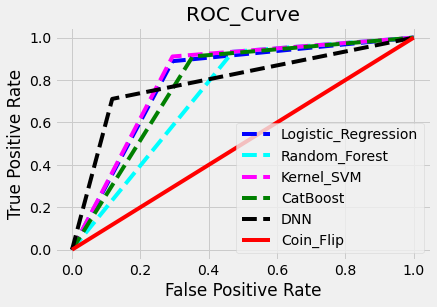

In [59]:
prob = [0 for i in range(len(y_test))]
prob_fpr, prob_tpr, threshold = roc_curve(y_test, prob, pos_label=1)

plt.plot(fpr_LR, tpr_LR, linestyle='--', color='blue', label='Logistic_Regression')
plt.plot(fpr_RFC, tpr_RFC, linestyle='--', color='cyan', label='Random_Forest')
plt.plot(fpr_KSV, tpr_KSV, linestyle='--', color='magenta', label='Kernel_SVM')
plt.plot(fpr_CBC, tpr_CBC, linestyle='--', color='green', label='CatBoost')
plt.plot(fpr_DNN, tpr_DNN, linestyle='--', color='black', label='DNN')
plt.plot(prob_fpr, prob_tpr, linestyle='-', color='red', label="Coin_Flip")
plt.title('ROC_Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.plot(figsize=(6, 6))
plt.show()

In [60]:
Classification_Report_Summary = (pd.concat([LR_Rep_df, RFC_Rep_df, KSV_Rep_df, CBC_Rep_df, DNN_Rep_df],
                keys=['LR_Rep_df', 'RFC_Rep_df', 'KSV_Rep_df', 'CBC_Rep_df', 'DNN_Rep_df'])).round(decimals=2)

In [61]:
print("------ Classification Report Summary ------")

------ Classification Report Summary ------


In [62]:
Classification_Report_Summary

precision  recall  f1-score  support
LR_Rep_df  0                  0.71    0.71      0.71    17.00
           1                  0.89    0.89      0.89    45.00
           accuracy           0.84    0.84      0.84     0.84
           macro avg          0.80    0.80      0.80    62.00
           weighted avg       0.84    0.84      0.84    62.00
RFC_Rep_df 0                  0.75    0.53      0.62    17.00
           1                  0.84    0.93      0.88    45.00
           accuracy           0.82    0.82      0.82     0.82
           macro avg          0.80    0.73      0.75    62.00
           weighted avg       0.82    0.82      0.81    62.00
KSV_Rep_df 0                  0.75    0.71      0.73    17.00
           1                  0.89    0.91      0.90    45.00
           accuracy           0.85    0.85      0.85     0.85
           macro avg          0.82    0.81      0.81    62.00
           weighted avg       0.85    0.85      0.85    62.00
CBC_Rep_df 0                  0.73    0.65      0.69    17.00
           1                  0.87    0.91      0.89    45.00
           accuracy           0.84    0.84      0.84     0.84
           macro avg          0.80    0.78      0.79    62.00
           weighted avg       0.83    0.84      0.84    62.00
DNN_Rep_df 0                  0.54    0.88      0.67    17.00
           1                  0.94    0.71      0.81    45.00
           accuracy           0.76    0.76      0.76     0.76
           macro avg          0.74    0.80      0.74    62.00
           weighted avg       0.83    0.76      0.77    62.00

### ------ Scenario 1 ------

Description:
    1. Full dataset is used, without dropping any outliers or features.
    2. Standard Scaler

Output:

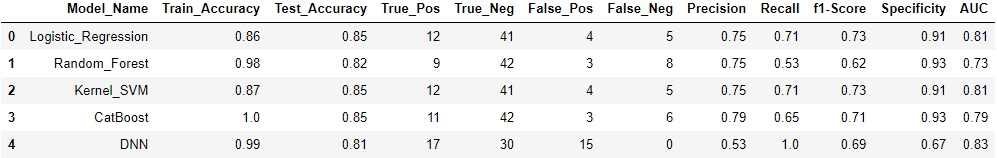

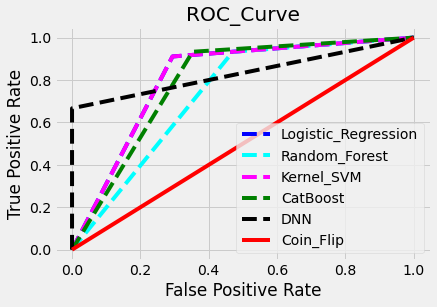

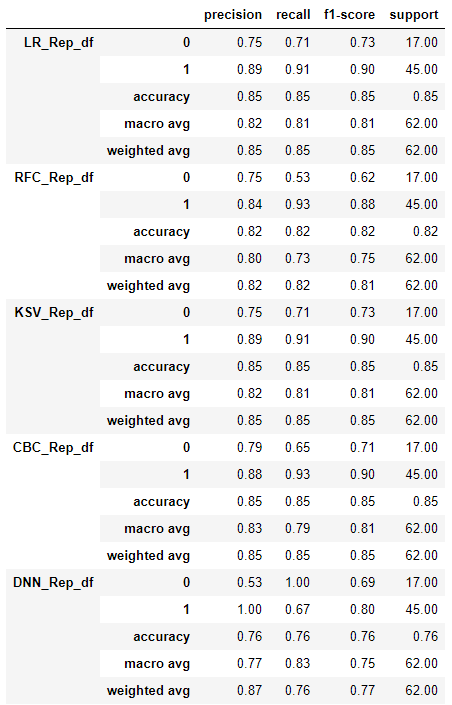

Conclusions:
    1. Logistic Regression & SVM models are better.
    2. Train & test accuracy are comparable indicating good generality.
    3. Recall for class label 1 (Patient) is 91% which is decent.


### ------ Scenario 2 ------

Description:
    1. pelvic_incidence is dropped from the dataset.
    2. Standard Scaler

Output:

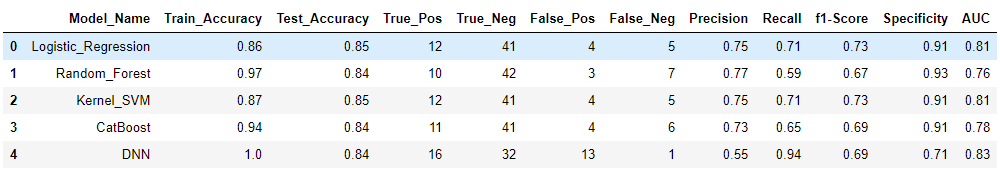

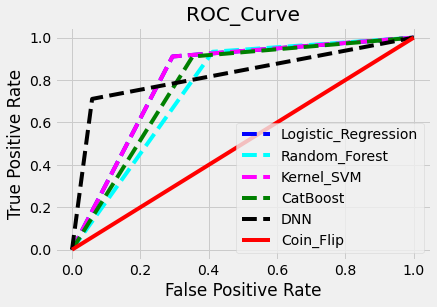

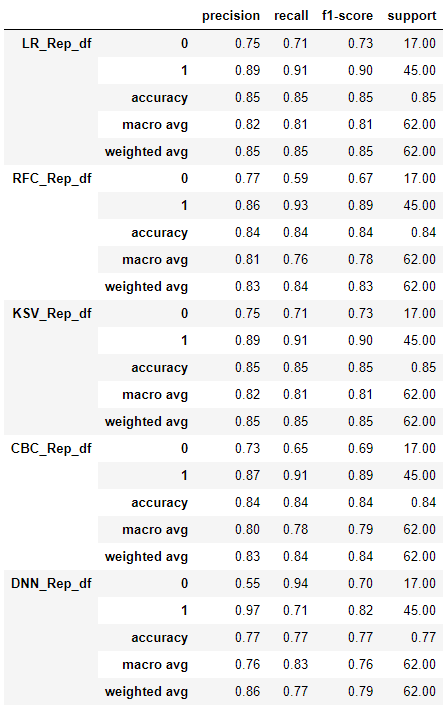

Conclusions:
    1. No major impact of dropping pelvic_incidence.
    2. DNN model does improve, however # of false positive for DNN is high.

### ------ Final Conclusions Recommendation ------

Conclusions:
    1. Kernel Support Vector Machines appears to be the best:
        - KSV = svm.SVC(kernel='linear', C=100, gamma=0.001, random_state=RND_STATE)
    2. This is based on well rounded parameters
        - Comparable train and test accuracy score.
        - False postives and negatives are low and comparable.
        - Recall is 91% for class label 1 is decent.
        - AUC of 0.81 - acceptable.

Recommendation:
    1. Two things can be tried to improve the scores better:
        a. Remove outliers and / or
        b. Downsample the dataset.

In [64]:
!jupyter nbconvert --output-dir="C:\DSML_Case_Studies\01_Classification\00_Final_Reports" MLM_CLF_Dataset_Back_Pain --to html --no-input

[NbConvertApp] Converting notebook MLM_CLF_Dataset_Back_Pain.ipynb to html
[NbConvertApp] Writing 929920 bytes to C:\DSML_Case_Studies\01_Classification\00_Final_Reports\MLM_CLF_Dataset_Back_Pain.html
